In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8289098023371925521
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 1573119590
locality {
  bus_id: 1
}
incarnation: 9383250688010432038
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0"
]


original image shape:  <PIL.Image.Image image mode=L size=224x224 at 0x23D18CD7048>


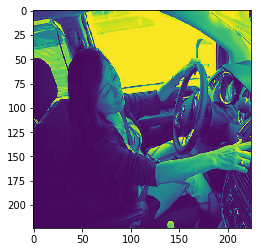

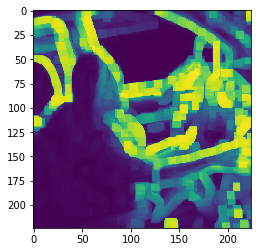

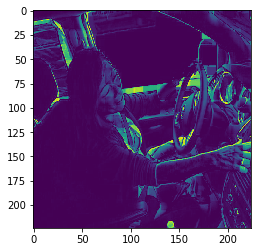

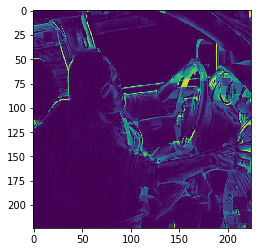

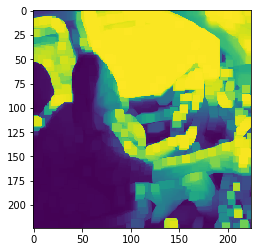

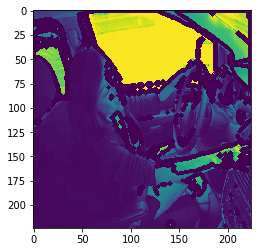

In [26]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from keras.preprocessing import image
from PIL import Image

def plot_histogram(image):
    hist,bins = np.histogram(image.flatten(),256,[0,256])

    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    plt.plot(cdf_normalized, color = 'b')
    plt.hist(image.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.show()

def equalize_histogram(img, grid_size):
    clahe = cv2.createCLAHE(tileGridSize=(grid_size,grid_size))
    cl1 = clahe.apply(img)
    return cl1

# img = cv2.imread('./images/train/c0/img_34.jpg', 0)
# equalized_img = equalize_histogram(img,16)
# plt.imshow(equalized_img)
# plt.show()
# plot_histogram(equalized_img)

# ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
# plt.imshow(equalized_img)
# plt.show()
# plot_histogram(equalized_img)

def equalize_histogram(local_img, grid_size):
#    local_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(tileGridSize=(grid_size,grid_size))
    equalized_img = clahe.apply(local_img)
    return equalized_img

def hisEqulColor(img):
    ycrcb=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
    channels=cv2.split(ycrcb)
    print ("channels: ", len(channels))
    cv2.equalizeHist(channels[0],channels[0])
    cv2.merge(channels,ycrcb)
    cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2BGR,img)
    return img
    
img = image.load_img('./images/train/c5/img_56.jpg', target_size=(224, 224), grayscale=True)
print("original image shape: ", img)
img = np.array(img)
# eq_img = equalize_histogram(img,16)
# plt.imshow(eq_img)
# plt.show()
# x = image.img_to_array(img)
# print(x.shape)
plt.imshow(img)
plt.show()

kernel = np.ones((8,8),np.uint8)
gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
plt.imshow(gradient)
plt.show()

tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
plt.imshow(tophat)
plt.show()

blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
plt.imshow(blackhat)
plt.show()

dilation = cv2.dilate(img,kernel,iterations = 1)
plt.imshow(dilation)
plt.show()

ret, thresh = cv2.threshold(img, 127, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour = cv2.drawContours(img, contours, -1, (0,255,0), 3)
plt.imshow(contour)
plt.show()


In [3]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model

import tensorflow as tf

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import load_model
import datetime, random, pickle
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.preprocessing import image
from tqdm import tqdm
from PIL import ImageFile
import cv2
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ActivityRegularization
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
import sys
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def loadImages(path):
    data = load_files(path)
    files = data['filenames']
    targets = data['target']
    target_names = data['target_names']
    return files, targets, target_names

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224), grayscale=True)
    img_array = np.array(img)
    #equalize histogram
    equalized_img = equalize_histogram(img_array, 16)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(equalized_img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)


def paths_to_tensor(img_paths):
    print (img_paths)
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# ## Load the Data

print ("Loading Images...")
path = "images/train"
files, targets, target_names = loadImages(path)
# predict_files = np.array(glob("images/test/*"))[1:10]
print('Number of Categories: ', len(target_names))
print('Categories: ', target_names)

# Split the original training sets into training & testing sets
train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=0.20, random_state=40)

print(train_files.shape, test_files.shape, train_targets.shape, test_targets.shape)
print(len(test_files))




Loading Images...
Number of Categories:  10
Categories:  ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
(15200,) (3800,) (15200,) (3800,)
3800


In [4]:
print ("Creating image tensors")

train_tensors = paths_to_tensor(train_files).astype('float32') / 255
test_tensors = paths_to_tensor(test_files).astype('float32') / 255

print("Size of train tensors: " + str(train_tensors.shape))
print("Size of test tensors: " + str(test_tensors.shape))
print("Size of test targets: " + str(test_targets.shape))


Creating image tensors
['images/train\\c3\\img_24663.jpg' 'images/train\\c8\\img_98810.jpg'
 'images/train\\c9\\img_67390.jpg' ..., 'images/train\\c7\\img_31727.jpg'
 'images/train\\c7\\img_82756.jpg' 'images/train\\c5\\img_21995.jpg']


100%|████████████████████████████████████████████████████████████████████████████| 15200/15200 [02:42<00:00, 93.37it/s]


['images/train\\c5\\img_68264.jpg' 'images/train\\c6\\img_69335.jpg'
 'images/train\\c2\\img_12280.jpg' ..., 'images/train\\c8\\img_6916.jpg'
 'images/train\\c6\\img_21610.jpg' 'images/train\\c5\\img_46343.jpg']


100%|██████████████████████████████████████████████████████████████████████████████| 3800/3800 [00:38<00:00, 99.44it/s]


Size of train tensors: (15200, 224, 224, 1)
Size of test tensors: (3800, 224, 224, 1)
Size of test targets: (3800,)


In [22]:
import glob
model_files = glob.glob('./saved_models/*.hdf5')
# model_files = os.listdir('./saved_models/')
# for f in model_files:
#     print(f)

model = load_model('./saved_models/create_model23dropout_0.12018-03-2765_complete_model.hdf5')
print (model.
distraction_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]


ValueError: Error when checking : expected conv2d_4_input to have shape (224, 224, 3) but got array with shape (224, 224, 1)